In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch import nn
from torch import optim
from torchvision import utils
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Stable Diffusion의 미세 조정 기법들

한 눈에 살펴보기

![](https://i.redd.it/vl01e5grs6ca1.png)

- Dreambooth: 새로운 데이터를 이해할 수 있을 때까지 Diffusion의 U-Net을 미세 조정
- LoRA: Diffuson 모델의 가중치를 유지한 채로 약간의 가중치를 추가한 후 가중치 변화량만을 학습
- Text Inversion: 새로운 데이터를 잘 이해하는 텍스트 임베딩을 생성
- Hypernetworks: 보조 네트워크를 사용하여 기존 네트워크의 훈련될 가중치를 예측하고 추론 시점에만 가중치를 변경

`huggingface_hub`로부터 데이터셋의 스냅샷을 가져옵니다. 미세 조정에 사용할 5장의 강아지 사진들이 포함되어 있습니다.

In [ ]:
from huggingface_hub import snapshot_download

# data_dir: 데이터 스냅샷을 다운로드 받은 경로를 저장
data_dir = snapshot_download(
    repo_id="diffusers/dog-example",
    local_dir="./dog",
    repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

alvan-nee-Id1DBHv4fbg-unsplash.jpeg:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

alvan-nee-eoqnr8ikwFE-unsplash.jpeg:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

alvan-nee-bQaAJCbNq3g-unsplash.jpeg:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

alvan-nee-9M0tSjb-cpA-unsplash.jpeg:   0%|          | 0.00/677k [00:00<?, ?B/s]

alvan-nee-brFsZ7qszSY-unsplash.jpeg:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

In [ ]:
import os
from IPython.display import display, Image

# 경로 내의 파일 리스팅
data_list = os.listdir(data_dir)
# 각 파일들을 시각화
for data in data_list:
    display(Image(f"{data_dir}/{data}", width=100))

5장의 강아지 데이터를 확인할 수 있습니다.

깃허브에서 클론해온 `diffusers`의 패키지의 `train_dreambooth_lora.py` 스크립트를 통해 주어진 데이터로 미세 조정을 진행합니다.

- pretrained_model_name_or_path: 사전 훈련된 Diffusion 모델로, 여기서는 huggingface hub의 모델을 불러옵니다.
- instance_data_dir: 미세 조정할 데이터가 포함된 디렉토리 경로
- output_dir: 훈련 과정 중 체크포인트를 저장할 경로
- instance_prompt: 고유 식별자와 이미지가 속한 클래스를 포함하는 텍스트 프롬프트
- resolution: 훈련할 이미지의 크기
- train_batch_size: 한 번의 연산에서 활용할 데이터의 개수
- gradient_accumulation_steps:
- checkpointing_steps: 체크포인트를 저장할 연산의 단위
- learning_rate: 학습률
- lr_scheduler: 학습률 조정 스케쥴러로 여기서는 상수로 지정하여 학습률을 고정합니다.
- max_train_steps: 총 연산 반복횟수
- validation_prompt: 검증에 활용할 텍스트 프롬프트
- validation_epochs: 검증할 에포크 단위
- seed: 재현을 위한 랜덤 시드값

In [ ]:
!python diffusers/examples/dreambooth/train_dreambooth_lora.py \
    --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
    --instance_data_dir="/content/dog" \
    --output_dir="db_lora" \
    --instance_prompt="a photo of sks dog" \
    --resolution=512 \
    --train_batch_size=1 \
    --gradient_accumulation_steps=1 \
    --checkpointing_steps=100 \
    --learning_rate=1e-4 \
    --lr_scheduler="constant" \
    --max_train_steps=500 \
    --validation_prompt="A photo of sks dog in a bucket" \
    --validation_epochs=50 \
    --seed=2023

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
2023-11-21 18:54:31.010556: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 18:54:31.010612: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 18:54:31.010650: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 18:54:33.149901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not f

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

model_base = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_base, torch_dtype=torch.float16, use_safetensors=True
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


`Pipeline`을 이용하여 추론할 때, `cross_attention_kwargs` 인자의 "scale"을 이용하여 가중치를 제어할 수 있습니다.

`scale=1`인 경우 미세 조정된 가중치를 모두 이용하고, `scale=0`인 경우 미세 조정된 가중치가 아닌 사전 훈련된 모델의 가중치만을 이용합니다.

In [ ]:
pipe.unet.load_attn_procs("db_lora/pytorch_lora_weights.safetensors")
pipe.to("cuda")

# LoRA로 미세 조정된 가중치의 절반과 사전 훈련된 모델의 가중치를 절반씩 활용합니다.
image = pipe(
    "A picture of a sks dog in a bucket.",
    num_inference_steps=25,
    guidance_scale=7.5,
    cross_attention_kwargs={"scale": 0.5},
).images[0]
image.save("bucket-dog-half.png")

# LoRA로 미세 조정된 가중치만 활용합니다.
image = pipe(
    "A picture of a sks dog in a bucket.",
    num_inference_steps=25,
    guidance_scale=7.5,
    cross_attention_kwargs={"scale": 0.99},
).images[0]
image.save("bucket-dog.png")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

서로 다른 가중치를 이용한 추론 결과를 비교합니다.

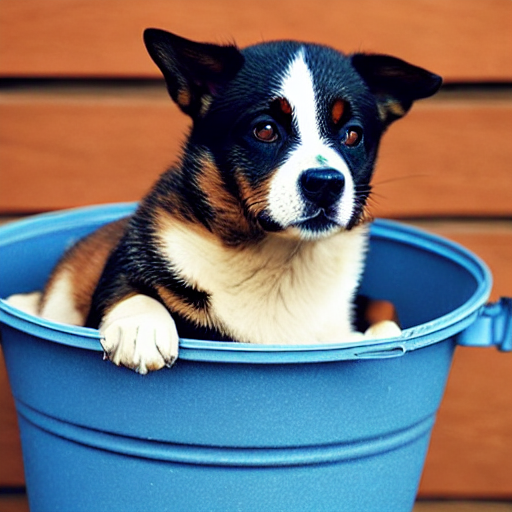

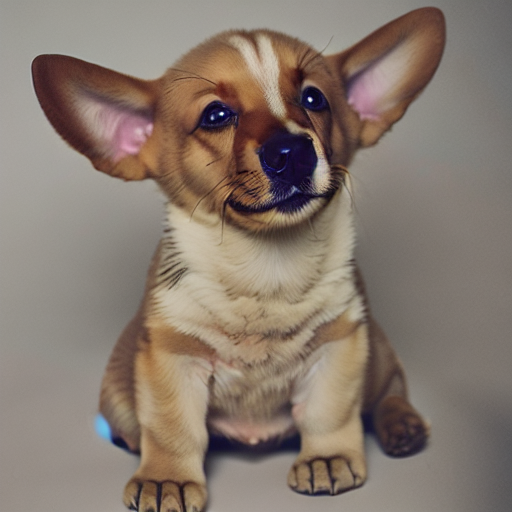

In [ ]:
import os
from IPython.display import display, Image

# 각 파일들을 시각화
for data in ["bucket-dog-half.png", "bucket-dog.png"]:
    display(Image(data, width=200))
    print()

스크립트 내부를 모르더라도 쉽게 모델을 미세 조정 할 수 있습니다. 하지만 자세한 동작 이해를 위해서는 스크립트가 어떻게 구성되어있는지 알아볼 필요가 있습니다. 스크립트 원문은 [train_dreambooth_lora.py](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth_lora.py)에서 확인하실 수 있습니다.

아래의 코드는 스크립트의 일부로써, LoRA의 흐름 설명을 위해 주요한 부분만을 포함합니다. 따라서 코드가 실제로 동작하지 않습니다.

사전 학습된 텍스트 인코더와 노이즈 스케쥴러, 오토 인코더와 U-Net을 `pretrained_model_name_or_path`로부터 가져옵니다.

In [ ]:
# 아래 코드는 실제로 동작하지 않는 예시입니다.
# 텍스트 인코더가 포함할 클래스들을 가져옵니다.
text_encoder_cls = import_model_class_from_model_name_or_path(
    args.pretrained_model_name_or_path
)

# 노이즈 스케쥴러를 비롯하여 모델들을 가져옵니다.
noise_scheduler = DDPMScheduler.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="scheduler"
)
text_encoder = text_encoder_cls.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet"
)

NameError: ignored

LoRA는 사전 훈련된 모델의 가중치 자체를 변경하는 것이 아닌, 추가적인 가중치를 두어 학습하는 방식이므로 현재 가중치들을 고정시킵니다.

In [ ]:
# LoRA 레이어를 제외한 나머지 구성 요소들은 학습하지 않을 것이므로 기울기를 추적하지 않습니다.
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

LoRA 학습을 위한 추가 가중치를 설정합니다. LoRA의 가중치는 U-Net의 어텐션 레이어에 추가됩니다.

In [ ]:
# LoRA 레이어를 설정합니다.
unet_lora_parameters = []
for attn_processor_name, attn_processor in unet.attn_processors.items():
    # U-Net의 어텐션 레이어 중 필요한 부분만 가져옵니다.
    attn_module = unet
    for n in attn_processor_name.split(".")[:-1]:
        attn_module = getattr(attn_module, n)

    # 어텐션 모듈에 LoRA 레이어를 속성으로 설정합니다.
    # 어텐션 모듈을 query, key, value로 이루어져 있으므로 각각 설정합니다.
    attn_module.to_q.set_lora_layer(
        LoRALinearLayer(
            in_features=attn_module.to_q.in_features,
            out_features=attn_module.to_q.out_features
        )
    )
    attn_module.to_k.set_lora_layer(
        LoRALinearLayer(
            in_features=attn_module.to_k.in_features,
            out_features=attn_module.to_k.out_features
        )
    )
    attn_module.to_v.set_lora_layer(
        LoRALinearLayer(
            in_features=attn_module.to_v.in_features,
            out_features=attn_module.to_v.out_features
        )
    )

    attn_module.to_out[0].set_lora_layer(
        LoRALinearLayer(
            in_features=attn_module.to_out[0].in_features,
            out_features=attn_module.to_out[0].out_features,
        )
    )

    # LoRA 파라미터를 훈련 파라미터에 추가합니다.
    unet_lora_parameters.extend(attn_module.to_q.lora_layer.parameters())
    unet_lora_parameters.extend(attn_module.to_k.lora_layer.parameters())
    unet_lora_parameters.extend(attn_module.to_v.lora_layer.parameters())
    unet_lora_parameters.extend(attn_module.to_out[0].lora_layer.parameters())

    # 어텐션 레이어의 프로젝션의 속성도 LoRA로 설정합니다.
    if isinstance(attn_processor, (AttnAddedKVProcessor, SlicedAttnAddedKVProcessor, AttnAddedKVProcessor2_0)):
        attn_module.add_k_proj.set_lora_layer(
            LoRALinearLayer(
                in_features=attn_module.add_k_proj.in_features,
                out_features=attn_module.add_k_proj.out_features,
            )
        )
        attn_module.add_v_proj.set_lora_layer(
            LoRALinearLayer(
                in_features=attn_module.add_v_proj.in_features,
                out_features=attn_module.add_v_proj.out_features,
            )
        )
        unet_lora_parameters.extend(
            attn_module.add_k_proj.lora_layer.parameters()
        )
        unet_lora_parameters.extend(
            attn_module.add_v_proj.lora_layer.parameters()
        )

Stable Diffusion 훈련 과정을 통해 LoRA 레이어를 훈련합니다.

In [ ]:
for epoch in range(first_epoch, args.num_train_epochs):
    unet.train()
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):
            pixel_values = batch["pixel_values"].to(dtype=weight_dtype)

            # 픽셀 공간에서 잠재 공간으로 이동
            model_input = vae.encode(pixel_values).latent_dist.sample()
            model_input = model_input * vae.config.scaling_factor

            # 정규 분포로부터 노이즈를 생성합니다.
            noise = torch.randn_like(model_input)
            bsz, channels, height, width = model_input.shape
            # 각 이미지에 대해 임의의 Timestep을 생성합니다.
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,(bsz,),
                device=model_input.device
            )
            timesteps = timesteps.long()

            # 순방향 확산 과정을 수행합니다.
            noisy_model_input = noise_scheduler.add_noise(
                model_input, noise, timesteps
            )

            # 텍스트 인코더를 통해 프롬프트에 대한 임베딩을 얻습니다.
            encoder_hidden_states = encode_prompt(
                text_encoder,
                batch["input_ids"],
                batch["attention_mask"],
            )

            if accelerator.unwrap_model(unet).config.in_channels == channels * 2:
                noisy_model_input = torch.cat(
                    [noisy_model_input, noisy_model_input], dim=1
                )

            # 노이즈의 잔차를 U-Net을 통해 예측합니다.
            class_labels = None
            model_pred = unet(
                noisy_model_input,
                timesteps,
                encoder_hidden_states,
                class_labels=class_labels
            ).sample

            # 모델이 분산을 예측하는 경우, 예측값을 버립니다.
            # 모델이 분산을 예측할지, 고정된 값을 예측할지 정해져야 합니다.
            if model_pred.shape[1] == 6:
                model_pred, _ = torch.chunk(model_pred, 2, dim=1)

            # 노이즈 스케쥴러가 값만을 이용하여 노이즈를 생성할지
            # 가속도를 포함하여 노이즈를 생성할지에 따라 타겟을 달리 설정합니다.
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(
                    model_input, noise, timesteps
                )

            # 모델의 예측값과 타겟을 이용해 MSE 손실을 계산합니다.
            loss = F.mse_loss(
                model_pred.float(), target.float(),
                reduction="mean"
            )

            # 기울기 역전파를 수행하여 LoRA 가중치를 업데이트 합니다.
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

일반적인 미세 조정

In [ ]:
!python diffusers/examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --dataset_name="lambdalabs/pokemon-blip-captions" \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=15000 \
  --learning_rate=1e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" --lr_warmup_steps=0 \
  --output_dir="lora" \
  --checkpointing_steps=500 \
  --validation_prompt="A pokemon with blue eyes." \
  --seed=1337

In [ ]:
pipe.unet.load_attn_procs("lora/pytorch_lora_weights.safetensors")
pipe.to("cuda")

image = pipe(
    "A pokemon with blue eyes.",
    num_inference_steps=25,
    guidance_scale=7.5,
    cross_attention_kwargs={"scale": 0.5}
).images[0]

image = pipe(
    "A pokemon with blue eyes.",
    num_inference_steps=25,
    guidance_scale=7.5
  ).images[0]
image.save("blue_pokemon.png")

#Reference
- [Low-Rank Adaptation of Large Language Models (LoRA)](https://huggingface.co/docs/diffusers/training/lora)